# Validation evaluation
This notebook was used to evaluate the validation step and its capacity to fix syntax errors in SPARQL queries.

In [ ]:
from pipeline.simple_llm_query_generator import SimpleLLMQueryGenerator
llm_generator = SimpleLLMQueryGenerator("gpt-4o-mini")
test_syntax_error_queries = ["""PREFIX sphn: <https://www.biomedit.ch/rdf/sphn-schema/sphn/>
SELECT ?patient WHERE {
  ?event sphn:hasSubjectPseudoIdentifier> ?patient ..
  ?event sphn:hasLabResult ?res .
  ?res sphn:hasQuantityValue ?val 
  FILTER(?val > 9.0)
}""",
"""SELECT ?patient WHERE {
  ?presc sphn:hasSubjectPseudoIdentifier ?patient .
  ?presc sphn: ?drug .
  ?drug sphn:hasCode ?code .
  ?code sphn:hasValue "M01AE01"
}""",
"""PREFIX sphn: <https://www.biomedit.ch/rdf/sphn-schema/sphn/>
SEL ?patient WHERE {
  ?event sphn:hasSubjectPseudoIdentifier ?patient .
  ?event sphn:hasLabResult ?res .
  ?res sphn:hasQuantityValue ?val .
  FILTER(?val > 9.0)
}""",
"""PREFIX sphn:  <https://www.biomedit.ch/rdf/sphn-schema/sphn/>
    SELECT ?patient WHERE {
      ?presc sphn:hasSubjectPseudoIdentifier> ?patient .
      ?presc sphn: ?drug .
      ?drug spn:hasCode ?code .
      ?code sphn:hasValue "M01AE01"
    }""",
"""PREFIX sphn: <https://www.biomedit.ch/rdf/sphn-schema/sphn/>
PREFIX icd: <https://www.biomedit.ch/rdf/sphn-schema/sphn/icd#>

SELECT (COUNT(*) AS ?numPatients) WHERE {
    SELECT DISTINCT ?patient WHERE {
      ?patient sphn:hasDiagnosis ?diag .
      ?diag sphn:hasCode ?code .
      ?code sphn:hasCodeValue icd:I422 .
    }
  }
}""",
"""PREFIX sphn:  <https://www.biomedit.ch/rdf/sphn schema/sphn/>
    SELECT ?patient WHERE {
      ?presc sphn:hasSubjectPseudoIdentifier> ?patient .
      ?presc sphn: ?drug .
      ?drug spn:hasCode ?code .
      ?code sphn:hasValue icd:M01AE01
    }"""
]

error_dict = {
  1: "extra dot",
2: "missing prefix",
3: "SEL instead of SELECT",
4: "Incorrect prefix keyword: spn instead of sphn",
5: "Missing '{'",
6: "No '' around M01AE01, icd: instead"
}

/home/mathiasyap/.local/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


4.52.4


In [ ]:
import pandas as pd

df_errors = pd.DataFrame({
    "Index": range(1, len(test_syntax_error_queries) + 1),
    "Error Type": [error_dict[j+1] for j in range(len(test_syntax_error_queries))],
    "Query": test_syntax_error_queries
})
df_errors
# for i, (query, error) in enumerate(zip(test_syntax_error_queries, [error_dict[j+1] for j in range(len(test_syntax_error_queries))])):
#     print(f"{i+1:<5} | {error:<45} | {query.replace(chr(10), ' ')}")

Index | Error Type                                   | Query


,Index,Error Type,Query
0,1,extra dot,PREFIX sphn: <https://www.biomedit.ch/rdf/sphn...
1,2,missing prefix,SELECT ?patient WHERE {\n ?presc sphn:hasSubj...
2,3,SEL instead of SELECT,PREFIX sphn: <https://www.biomedit.ch/rdf/sphn...
3,4,Incorrect prefix keyword: spn instead of sphn,PREFIX sphn: <https://www.biomedit.ch/rdf/sph...
4,5,Missing '{',PREFIX sphn: <https://www.biomedit.ch/rdf/sphn...
5,6,"No '' around M01AE01, icd: instead",PREFIX sphn: <https://www.biomedit.ch/rdf/sph...


In [2]:
test_syntax_error_queries

['PREFIX sphn: <https://www.biomedit.ch/rdf/sphn-schema/sphn/>\nSELECT ?patient WHERE {\n  ?event sphn:hasSubjectPseudoIdentifier> ?patient ..\n  ?event sphn:hasLabResult ?res .\n  ?res sphn:hasQuantityValue ?val \n  FILTER(?val > 9.0)\n}',
 'SELECT ?patient WHERE {\n  ?presc sphn:hasSubjectPseudoIdentifier ?patient .\n  ?presc sphn: ?drug .\n  ?drug sphn:hasCode ?code .\n  ?code sphn:hasValue "M01AE01"\n}',
 'PREFIX sphn: <https://www.biomedit.ch/rdf/sphn-schema/sphn/>\nSEL ?patient WHERE {\n  ?event sphn:hasSubjectPseudoIdentifier ?patient .\n  ?event sphn:hasLabResult ?res .\n  ?res sphn:hasQuantityValue ?val .\n  FILTER(?val > 9.0)\n}',
 'PREFIX sphn:  <https://www.biomedit.ch/rdf/sphn-schema/sphn/>\n    SELECT ?patient WHERE {\n      ?presc sphn:hasSubjectPseudoIdentifier> ?patient .\n      ?presc sphn: ?drug .\n      ?drug spn:hasCode ?code .\n      ?code sphn:hasValue "M01AE01"\n    }',
 'PREFIX sphn: <https://www.biomedit.ch/rdf/sphn-schema/sphn/>\nPREFIX icd: <https://www.biom

In [3]:

import millenniumdb_driver
import traceback
from pipeline.query_engine_component import QueryExecutorStep
query_executor = QueryExecutorStep(engine_name = "milleniumDB", graph_path="rdf_400_sphn_augmented_hybrid.ttl",construct_graph=False)

['mdb:latest']
['docker-aseprite:latest']
['ghcr.io/avantlab/avantgraph:openaire-transport']
['ghcr.io/avantlab/avantgraph:openaire-energy']
['ghcr.io/avantlab/avantgraph:openaire-neuro']
['ghcr.io/avantlab/avantgraph:openaire-cancer']
['hello-world:latest']
['ghcr.io/avantlab/avantgraph:ckg']
['ghcr.io/avantlab/avantgraph:release-2024-01-31']


In [4]:
#  getting the generic data
import time


sparql_incorrect_str = "SPARQL Syntax Error: The format of the query is incorrect"
generic_error_string = sparql_incorrect_str
generic_error_data_list = []
for test_query in test_syntax_error_queries:
    start_time = time.time()
    data = {}
    data['query'] = test_query
    data["validation_time"] = []
    data["valid_query"] = False
    llm_generator.tries = 0
    while(llm_generator.tries <= llm_generator.max_tries):
        try:
            # print(f"\n🧠 Attempt {self.llm_generator.tries}: Executing query...\n{data["query"]}\n")
            # Execute the query using the query executor
            data = query_executor.run(data)
            data["valid_query"] = True
            break

        except millenniumdb_driver.MillenniumDBError:
            full_traceback =  traceback.format_exc()
            error_message = ""
            for line in full_traceback.splitlines():
                if "Query Exception:" in line:
                    error_message = line.split("Query Exception:")[1]
            if llm_generator.tries >= llm_generator.max_tries:
                print("❌ Maximum attempts reached. Unable to generate a valid query.")
                print("Failed query: " + data["query"])
                print("Error message: " + error_message)
                break
            data = llm_generator.handle_query_error(data,generic_error_string)
    
    data["time_verifying"] = time.time()-start_time
    generic_error_data_list.append(data)


Cost (USD): $0.000095
Cost (USD): $0.000081
Cost (USD): $0.000082
Cost (USD): $0.000082
❌ Maximum attempts reached. Unable to generate a valid query.
Failed query: SELECT ?patient WHERE {
  ?presc sphn:hasSubjectPseudoIdentifier ?patient .
  ?presc sphn:hasMedication ?drug .
  ?drug sphn:hasCode ?code .
  ?code sphn:hasValue "M01AE01" .
}
Error message:  Bad query semantic: `The prefix 'sphn' is not defined`.
Cost (USD): $0.000095
Cost (USD): $0.000099
Cost (USD): $0.000115
Cost (USD): $0.000100
Cost (USD): $0.000099
Cost (USD): $0.000101
❌ Maximum attempts reached. Unable to generate a valid query.
Failed query: PREFIX sphn: <https://www.biomedit.ch/rdf/sphn schema/sphn/>
SELECT ?patient WHERE {
  ?presc sphn:hasSubjectPseudoIdentifier ?patient .
  ?presc sphn:hasDrug ?drug .
  ?drug sphn:hasCode ?code .
  ?code sphn:hasValue <http://icd.codes/M01AE01>
}
Error message:  mismatched input '<' expecting IRIREF


In [5]:
import pandas as pd

df_generic_error = pd.DataFrame(generic_error_data_list)
df_generic_error

,query,validation_time,valid_query,attempts,result,final_query_execution_time,time_verifying
0,PREFIX sphn: <https://www.biomedit.ch/rdf/sphn...,[],True,1,[],0.002681,1.608273
1,SELECT ?patient WHERE {\n ?presc sphn:hasSubj...,[],False,3,NaN,NaN,6.667113
2,PREFIX sphn: <https://www.biomedit.ch/rdf/sphn...,[],True,1,[],0.001739,1.597018
3,PREFIX sphn: <https://www.biomedit.ch/rdf/sph...,[],True,1,[{'patient': http://kg-representation-ehr.org/...,0.011593,1.808605
4,PREFIX sphn: <https://www.biomedit.ch/rdf/sphn...,[],True,1,[{'numPatients': 0}],0.006623,3.328844
5,PREFIX sphn: <https://www.biomedit.ch/rdf/sphn...,[],False,3,NaN,NaN,8.614784


In [6]:

specific_error_data_list = []
for test_query in test_syntax_error_queries:
    start_time = time.time()
    data = {}
    data['query'] = test_query
    data["validation_time"] = []
    data["valid_query"] = False
    llm_generator.tries = 0
    while(llm_generator.tries <= llm_generator.max_tries):
        try:
            # print(f"\n🧠 Attempt {self.llm_generator.tries}: Executing query...\n{data["query"]}\n")
            # Execute the query using the query executor
            data = query_executor.run(data)
            data["valid_query"] = True
            break

        except millenniumdb_driver.MillenniumDBError:
            full_traceback =  traceback.format_exc()
            error_message = ""
            for line in full_traceback.splitlines():
                if "Query Exception:" in line:
                    error_message = line.split("Query Exception:")[1]
            if llm_generator.tries >= llm_generator.max_tries:
                print("❌ Maximum attempts reached. Unable to generate a valid query.")
                print("Failed query: " + data["query"])
                print("Error message: " + error_message)
                break
            data = llm_generator.handle_query_error(data,error_message)
    
    data["time_verifying"] = time.time()-start_time
    specific_error_data_list.append(data)
        

Cost (USD): $0.000107
Cost (USD): $0.000090
Cost (USD): $0.000096
Cost (USD): $0.000110
Cost (USD): $0.000114
Cost (USD): $0.000099
Cost (USD): $0.000098
Cost (USD): $0.000107


In [7]:

df_specific_error = pd.DataFrame(specific_error_data_list)
df_specific_error

,query,validation_time,valid_query,attempts,result,final_query_execution_time,time_verifying
0,PREFIX sphn: <https://www.biomedit.ch/rdf/sphn...,[],True,1,[],0.001961,1.715380
1,PREFIX sphn: <http://example.org/sphn#>\nSELEC...,[],True,1,[],0.001927,1.384734
2,PREFIX sphn: <https://www.biomedit.ch/rdf/sphn...,[],True,1,[],0.002058,2.040747
3,PREFIX sphn: <https://www.biomedit.ch/rdf/sph...,[],True,1,[{'patient': http://kg-representation-ehr.org/...,0.010880,1.370281
4,PREFIX sphn: <https://www.biomedit.ch/rdf/sphn...,[],True,1,[{'numPatients': 0}],0.003302,2.345854
5,PREFIX sphn: <https://www.biomedit.ch/rdf/sphn...,[],True,3,[],0.001924,6.378679


In [9]:
error_dict

{1: 'missing dots',
 2: 'missing prefix',
 3: 'SEL instead of SELECT',
 4: 'missing prefix keyword: spn instead of sphn',
 5: "Missing '{'",
 6: "No '' around M01AE01, icd: instead"}

In [10]:
import re

# Merge the two DataFrames for side-by-side comparison
comparison_df = pd.DataFrame({
    'Generic_time_verifying': df_generic_error['time_verifying'],
    'Specific_time_verifying': df_specific_error['time_verifying'],
    'Generic_valid_query': df_generic_error['valid_query'],
    'Specific_valid_query': df_specific_error['valid_query'],
    'Generic_attempts': df_generic_error['attempts'],
    'Specific_attempts': df_specific_error['attempts'],
    'Generic_query': df_generic_error['query'],
    'Specific_query': df_specific_error['query'],
})

comparison_df
# Check if the final queries are the same as the respective proper_queries entry (ignoring whitespace)
def normalize_query(q):
    return ''.join(q.split())

def normalize_query(q):
    # Remove all whitespace and newlines and formatting characters
    return re.sub(r'\s+', '', q)

comparison_df


,Generic_time_verifying,Specific_time_verifying,Generic_valid_query,Specific_valid_query,Generic_attempts,Specific_attempts,Generic_query,Specific_query
0,1.608273,1.715380,True,True,1,1,PREFIX sphn: <https://www.biomedit.ch/rdf/sphn...,PREFIX sphn: <https://www.biomedit.ch/rdf/sphn...
1,6.667113,1.384734,False,True,3,1,SELECT ?patient WHERE {\n ?presc sphn:hasSubj...,PREFIX sphn: <http://example.org/sphn#>\nSELEC...
2,1.597018,2.040747,True,True,1,1,PREFIX sphn: <https://www.biomedit.ch/rdf/sphn...,PREFIX sphn: <https://www.biomedit.ch/rdf/sphn...
3,1.808605,1.370281,True,True,1,1,PREFIX sphn: <https://www.biomedit.ch/rdf/sph...,PREFIX sphn: <https://www.biomedit.ch/rdf/sph...
4,3.328844,2.345854,True,True,1,1,PREFIX sphn: <https://www.biomedit.ch/rdf/sphn...,PREFIX sphn: <https://www.biomedit.ch/rdf/sphn...
5,8.614784,6.378679,False,True,3,3,PREFIX sphn: <https://www.biomedit.ch/rdf/sphn...,PREFIX sphn: <https://www.biomedit.ch/rdf/sphn...


In [19]:
comparison_df['error_type'] = [error_dict[i+1] for i in range(len(comparison_df))]
comparison_df

,Generic_time_verifying,Specific_time_verifying,Generic_valid_query,Specific_valid_query,Generic_attempts,Specific_attempts,Generic_query,Specific_query,error_type
0,1.608273,1.715380,True,True,1,1,PREFIX sphn: <https://www.biomedit.ch/rdf/sphn...,PREFIX sphn: <https://www.biomedit.ch/rdf/sphn...,extra dot
1,6.667113,1.384734,False,True,3,1,SELECT ?patient WHERE {\n ?presc sphn:hasSubj...,PREFIX sphn: <http://example.org/sphn#>\nSELEC...,missing prefix
2,1.597018,2.040747,True,True,1,1,PREFIX sphn: <https://www.biomedit.ch/rdf/sphn...,PREFIX sphn: <https://www.biomedit.ch/rdf/sphn...,SEL instead of SELECT
3,1.808605,1.370281,True,True,1,1,PREFIX sphn: <https://www.biomedit.ch/rdf/sph...,PREFIX sphn: <https://www.biomedit.ch/rdf/sph...,Incorrect prefix keyword: spn instead of sphn
4,3.328844,2.345854,True,True,1,1,PREFIX sphn: <https://www.biomedit.ch/rdf/sphn...,PREFIX sphn: <https://www.biomedit.ch/rdf/sphn...,Missing '{'
5,8.614784,6.378679,False,True,3,3,PREFIX sphn: <https://www.biomedit.ch/rdf/sphn...,PREFIX sphn: <https://www.biomedit.ch/rdf/sphn...,"No '' around M01AE01, icd: instead"


In [24]:
summary = []

for error in comparison_df['error_type'].unique():
    subset = comparison_df[comparison_df['error_type'] == error]
    for idx, row in subset.iterrows():
        summary.append({
            'error_type': error,
            'Generic_time_verifying': row['Generic_time_verifying'],
            'Specific_time_verifying': row['Specific_time_verifying'],
            'Generic_failed_validation': not row['Generic_valid_query'],
            'Specific_failed_validation': not row['Specific_valid_query']
        })

summary_df = pd.DataFrame(summary)
summary_df

,error_type,Generic_time_verifying,Specific_time_verifying,Generic_failed_validation,Specific_failed_validation
0,extra dot,1.608273,1.715380,False,False
1,missing prefix,6.667113,1.384734,True,False
2,SEL instead of SELECT,1.597018,2.040747,False,False
3,Incorrect prefix keyword: spn instead of sphn,1.808605,1.370281,False,False
4,Missing '{',3.328844,2.345854,False,False
5,"No '' around M01AE01, icd: instead",8.614784,6.378679,True,False


In [25]:
summary_df['Generic_failed_validation'] = ~summary_df['Generic_failed_validation']
summary_df['Specific_failed_validation'] = ~summary_df['Specific_failed_validation']
summary_df.rename(columns={
    'Generic_failed_validation': 'Generic succeeded to correct sparql',
    'Specific_failed_validation': 'Specific succeeded to correct sparql'
}, inplace=True)
summary_df

,error_type,Generic_time_verifying,Specific_time_verifying,Generic succeeded to correct sparql,Specific succeeded to correct sparql
0,extra dot,1.608273,1.715380,True,True
1,missing prefix,6.667113,1.384734,False,True
2,SEL instead of SELECT,1.597018,2.040747,True,True
3,Incorrect prefix keyword: spn instead of sphn,1.808605,1.370281,True,True
4,Missing '{',3.328844,2.345854,True,True
5,"No '' around M01AE01, icd: instead",8.614784,6.378679,False,True


In [26]:
# Convert summary_df to a LaTeX table
latex_table = summary_df.to_latex(index=False, caption="Comparison of Generic vs Specific Error String Correction", label="tab:correction_summary")
print(latex_table)

\begin{table}
\caption{Comparison of Generic vs Specific Error String Correction}
\label{tab:correction_summary}
\begin{tabular}{lrrrr}
\toprule
error_type & Generic_time_verifying & Specific_time_verifying & Generic succeeded to correct sparql & Specific succeeded to correct sparql \\
\midrule
extra dot & 1.608273 & 1.715380 & True & True \\
missing prefix & 6.667113 & 1.384734 & False & True \\
SEL instead of SELECT & 1.597018 & 2.040747 & True & True \\
Incorrect prefix keyword: spn instead of sphn & 1.808605 & 1.370281 & True & True \\
Missing '{' & 3.328844 & 2.345854 & True & True \\
No '' around M01AE01, icd: instead & 8.614784 & 6.378679 & False & True \\
\bottomrule
\end{tabular}
\end{table}



In [13]:
comparison_df['Specific_query'][1]

'PREFIX sphn: <http://example.org/sphn#>\nSELECT ?patient WHERE {\n  ?presc sphn:hasSubjectPseudoIdentifier ?patient .\n  ?presc sphn:hasDrug ?drug .\n  ?drug sphn:hasCode ?code .\n  ?code sphn:hasValue "M01AE01"\n}'

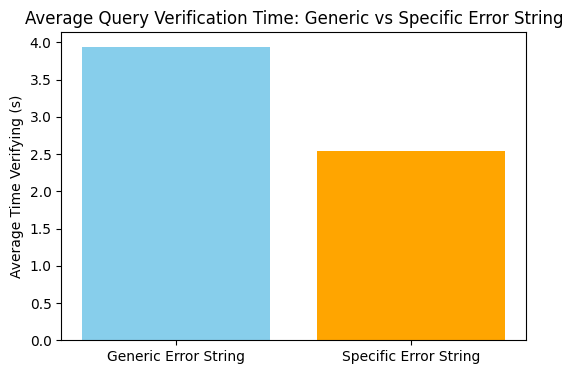

In [14]:
import matplotlib.pyplot as plt

# Calculate the average time for each method
avg_generic = summary_df['Generic_time_verifying'].mean()
avg_specific = summary_df['Specific_time_verifying'].mean()

# Plotting
plt.figure(figsize=(6,4))
plt.bar(['Generic Error String', 'Specific Error String'], [avg_generic, avg_specific], color=['skyblue', 'orange'])
plt.ylabel('Average Time Verifying (s)')
plt.title('Average Query Verification Time: Generic vs Specific Error String')
plt.show()

In [15]:
comparison_df['Specific_query'][3]

'PREFIX sphn:  <https://www.biomedit.ch/rdf/sphn-schema/sphn/>\nSELECT ?patient WHERE {\n  ?presc sphn:hasSubjectPseudoIdentifier ?patient .\n  ?presc sphn:hasDrug ?drug .\n  ?drug sphn:hasCode ?code .\n  ?code sphn:hasValue "M01AE01"\n}'

In [16]:
proper_queries[1]

NameError: name 'proper_queries' is not defined